## Graph Based Segmentation
This is a project uses Graph for Segmentation according to **Efficient Graph Based Segmentation paper (Pedro F. Felzenszwalb and Daniel P. Huttenlocher)**.  
You can find the paper [here](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf).  
This notebook is used for implementing that algorithm step by step.  
Before we start, let's load the packages and dependencies.  
In this notebook, we use a package named OpenCV for image reading. Search the Internet for installation.  

In [1]:
import numpy as np #numpy for numeric calculation
import cv2 #Open CV just for image reading
import matplotlib.pyplot as plt #For showing image

In [2]:
img=cv2.imread('Images/Figure1.jpg',cv2.IMREAD_COLOR)
print('Shape of the image is: '+str(img.shape))
print('Range of the pixel '+str(np.min(img))+' '+str(np.max(img)))

Shape of the image is: (488, 660, 3)
Range of the pixel 0 243


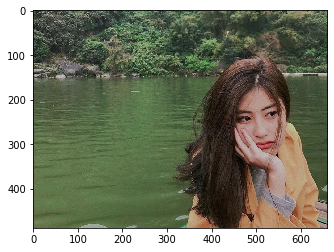

In [3]:
#show the image
#Firstly,convert BGR image (read from OpenCV) to RGB
if(len(img.shape)==3):img=img[:,:,::-1] #Only for RGB
plt.imshow(img)
plt.show()

Before going deeper to the Algorithm, the authors advise us to use Gaussian Filter to smooth the image.  
Now, implement Gauss Filter to the image.  
We don't use Gauss Filter in OpenCV, let's build our Gauss Filter algorithm ourselves.  
### I.Preprocessing: Gaussian Filter

In [4]:
#Build the convolutional operator
def convolve(img,kernel):
    '''
    Convolutional Operator between the origin_img and kernel
    Parameters:
    img: image, a 2D numpy array.
    kernel: the filter.
    return:
    convolved_img: the numpy array after convolving.
    '''
    #We want to keep the shape as close as possible to the image shape, so we use zero_padding
    pad_h=(kernel.shape[0]-1)//2 #pad at h dimension
    pad_w=(kernel.shape[1]-1)//2 #pad at w dimension
    #Calculate the new shape of the image
    convolved_h=img.shape[0]-kernel.shape[0]+2*pad_h+1
    convolved_w=img.shape[1]-kernel.shape[1]+2*pad_w+1
    #Use zero padding
    img=np.pad(img,pad_width=((pad_h,pad_h),(pad_w,pad_w)),mode='constant',constant_values=(0,0))
    # Initialize the new convolved_img
    convolved_img=np.zeros((convolved_h,convolved_w)).astype(int)
    for h in range(convolved_h):
        for w in range(convolved_w):
            slice=img[h:h+kernel.shape[0],w:w+kernel.shape[1]]
            convolved_img[h,w]=int(np.sum(slice*kernel))
            if(convolved_img[h,w]<0):convolved_img[h,w]%=255
            elif(convolved_img[h,w]>255):convolved_img[h,w]%=255
    return convolved_img

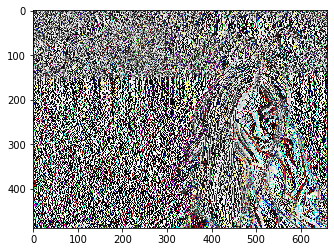

In [5]:
#Test with filter for detecting vertical edge
kernel=np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
convolved_img1=convolve(img[:,:,0],kernel)
convolved_img2=convolve(img[:,:,1],kernel)
convolved_img3=convolve(img[:,:,2],kernel)
convolved_img=np.zeros((convolved_img1.shape[0],convolved_img1.shape[1],3)).astype(int)
convolved_img[:,:,0]=convolved_img1
convolved_img[:,:,1]=convolved_img2
convolved_img[:,:,2]=convolved_img3
plt.imshow(convolved_img)
plt.show()

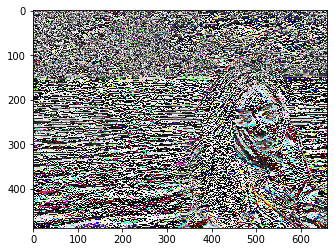

In [6]:
#Test with filter for detecting horizontal edge
kernel=np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
convolved_img1=convolve(img[:,:,0],kernel)
convolved_img2=convolve(img[:,:,1],kernel)
convolved_img3=convolve(img[:,:,2],kernel)
convolved_img[:,:,0]=convolved_img1
convolved_img[:,:,1]=convolved_img2
convolved_img[:,:,2]=convolved_img3
plt.imshow(convolved_img)
plt.show()

Gaussian Filtering

In [7]:
def create_gauss_filter(sigma=0.8,kernel_size=5):
    '''
    Create a filter for Gaussian filter.
    Parameters:
    sigma: standard deviation for the Gaussian Filter.
    kernel_size: kernel size for the filter
    return:
    a filter with shape=(kernel_size,kernel_size)
    '''
    #Initialize the kernel
    kernel=np.zeros((kernel_size,kernel_size))
    n_H=kernel_size//2 #height from -n_H to n_H
    n_W=kernel_size//2 #width from -n_W to n_W
    for h in range(-n_H,n_H+1):
        for w in range(-n_W,n_W+1):
            first_partition=1/(2*np.pi*(sigma**2))
            second_partition=np.exp(-(h**2+w**2)/(2*(sigma**2)))
            kernel[h+n_H,w+n_W]=first_partition*second_partition
    return kernel

In [8]:
def gaussian_filter(img,sigma,kernel_size=5):
    '''
    Apply the Gaussian Filter to the Image
    img: image, can be 2D array for grayscale image or 3D array for RGB Image
    sigma: standard deviation for Gaussian Filter
    kernel_size: size of kernel
    return:
    filter image
    '''
    kernel=create_gauss_filter(sigma,kernel_size) #Create a mask
    if(len(img.shape)==2):
        #This case is grayscale image
        img_filter=convolve(img,kernel)
    else:
        #RGB Image
        img_filter1=convolve(img[:,:,0],kernel)
        img_filter2=convolve(img[:,:,1],kernel)
        img_filter3=convolve(img[:,:,2],kernel)
        img_filter=np.zeros((img_filter1.shape[0],img_filter1.shape[1],3)).astype(int)
        img_filter[:,:,0]=img_filter1
        img_filter[:,:,1]=img_filter2
        img_filter[:,:,2]=img_filter3
    return img_filter

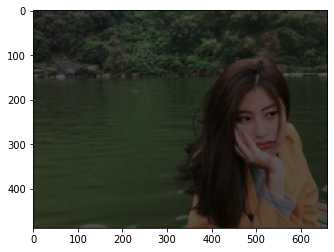

In [9]:
#Test
img_filter=gaussian_filter(img,sigma=2.5,kernel_size=5)
plt.imshow(img_filter)
plt.show()

### II. Main Algorithm
#### 1.Abstract  
The algorithm has 2 properties:  
- Capture perceptual important grouping or regions, which often reflect global aspect of the image.  
- Run highly efficient, running in time linear the number of the pixel.  

This technique adjusts the segmentation criterion based on the degree of variability in neighboring regions of the image. It preserves the low-variability regions while ignores the high-variability regions.  
#### 2. Form the Graph
(sử dụng tiếng Việt)  
Một số định nghĩa:  
Chúng ta sử dụng đồ thị để biểu diễn bức ảnh. Mỗi đỉnh trong đồ thị tương ứng với một pixel. Mỗi cạnh của đồ thị nối với 2 đỉnh, đối với 2 đỉnh $v_i$ và $v_j$, ta kí hiệu cạnh nối giữa chúng là $(v_i,v_j)$. Trên cạnh này được đánh một trọng số không âm $w((v_i,v_j))$, phản ánh sự khác nhau giữa 2 pixel $v_i$ và $v_j$. Sự khác nhau này có thể là sự khác nhau về pixel intensity, motion, shape, location,... Để đơn giản, ta coi trọng số mỗi cạnh là sự khác biệt giữa pixel intensities.  
Một điều mà ta quan tâm nữa đó là các cạnh của Graph được hình thành như thế nào? Chúng ta sẽ chọn mỗi pixel của Graph được nối tới 8 pixels kề với nó (trừ những pixel ở 2 biên). Trọng số cạnh $w((v_i,v_j))=|I(v_i)-I(v_j)|$.  
Trong chương trình, chúng ta sẽ cài đặt Graph bằng danh sách cạnh.  

In [10]:
class Edge:
    '''
    Edge class in Graph.
    '''
    def __init__(self,first_ver,second_ver,weight):
        '''
        Initialize an edge.
        Parameters:
        first_ver: a tuple represents the first vertice of the Edge
        second_ver: a tuple represents the second vertice of the Edge
        weight: weight on that Edge
        '''
        self.first=first_ver
        self.second=second_ver
        self.weight=weight

In [11]:
def construct_graph(img):
    '''
    Constructing Graph from img
    Parameters:
    img: 2D array for constructing Graph
    return:
    list of edges represent the constructed Graph
    '''
    graph=[] #Edge list
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(j+1<img.shape[1]):
                edge=Edge((i,j),(i,j+1),np.abs(img[i,j+1]-img[i,j]))
                graph.append(edge)
            if(i+1<img.shape[0]):
                edge=Edge((i,j),(i+1,j),np.abs(img[i+1,j]-img[i,j]))
                graph.append(edge)
            if(i+1<img.shape[0] and j+1<img.shape[1]):
                edge=Edge((i,j),(i+1,j+1),np.abs(img[i+1,j+1]-img[i,j]))
                graph.append(edge)
            if(i+1<img.shape[0] and j-1>=0):
                edge=Edge((i,j),(i+1,j-1),np.abs(img[i+1,j-1]-img[i,j]))
                graph.append(edge)
    return graph

Đối với ảnh Grayscale, chúng ta cứ feed nó vào hàm ``construct_graph``, còn đối với ảnh RGB, chúng ta phải feed từng channel vào hàm.  
Kiểm  tra hàm ``contruct_graph``, lưu ý nếu ta có 1 bức ảnh cỡ (m,n), thì số cạnh được tạo ra trong Graph là $\frac{8(m-2)(n-2)+3.4+2.5.(m-2)+2.5.(n-2)}{2}$.  
Trước khi đi vào kiểm tra, ta sử dụng Gaussian Filter cho ảnh với ``sigma=0.8``, ``kernel_size=5``.

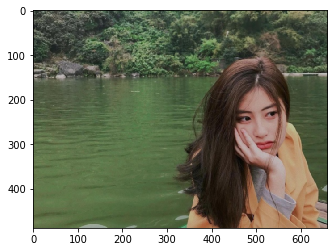

In [12]:
img_filter=gaussian_filter(img,sigma=0.8,kernel_size=5)
%matplotlib inline
plt.imshow(img_filter)
plt.show()

In [13]:
graph=construct_graph(img_filter[0:3,0:3,0])
print('The slice: ')
print(img_filter[0:3,0:3,0])
for edge in graph:
    print(str(edge.first)+' '+str(edge.second)+' '+str(edge.weight))
print(len(graph))

The slice: 
[[39 51 45]
 [49 63 62]
 [64 81 76]]
(0, 0) (0, 1) 12
(0, 0) (1, 0) 10
(0, 0) (1, 1) 24
(0, 1) (0, 2) 6
(0, 1) (1, 1) 12
(0, 1) (1, 2) 11
(0, 1) (1, 0) 2
(0, 2) (1, 2) 17
(0, 2) (1, 1) 18
(1, 0) (1, 1) 14
(1, 0) (2, 0) 15
(1, 0) (2, 1) 32
(1, 1) (1, 2) 1
(1, 1) (2, 1) 18
(1, 1) (2, 2) 13
(1, 1) (2, 0) 1
(1, 2) (2, 2) 14
(1, 2) (2, 1) 19
(2, 0) (2, 1) 17
(2, 1) (2, 2) 5
20


In [14]:
graph=construct_graph(img_filter[:,:,0])
print("The number of edges are "+str(len(graph)))
m=img_filter.shape[0]
n=img_filter.shape[1]
print("Actual edge number "+str(4*(m-2)*(n-2)+5*(m-2)+5*(n-2)+6))

The number of edges are 1284878
Actual edge number 1284878


Có vẻ ổn đó, như vậy là ta tạm qua phần test cho việc xây dựng Graph, bây giờ hãy tiếp tục bàn về thuật toán.  
Mục tiêu của ta là phải thực hiện Segment cho ảnh, có nghĩa là từ bức ảnh ban đầu, ta phải phân chia các pixels ra thành nhiều regions. Đó là mục tiêu của Segmentation.  
Trong hướng tiếp cận bằng Graph, một Segmentation S là một cách phân chia đồ thị thành các vùng, mà mỗi một vùng C được đặc trưng bởi một tập con của tập đỉnh và tập cạnh.  
Một cách phân chia tốt phải là một cách phân chia sao cho trong một region, sự khác biệt (cụ thể ở đây là những pixels) là không lớn, và giữa 2 regions với nhau, thì phải có sự khác biệt lớn đối với nhau. Điều này có nghĩa là những cạnh trong 1 components phải có trọng số nhỏ, còn các cạnh nối 2 component với nhau có trọng số lớn. Chúng ta phải định nghĩa một tiêu chuẩn cho việc phân chia các components.  
#### 3.Pairwise Region Comparision Predicate
Chúng ta định nghĩa một predicate D, để ước đoán rằng liệu có 1 boundary giữa 2 components hay không. Predicate này dựa trên việc đo đạc sự giống nhau trong cùng 1 component và sự khác nhau giữa 2 components với nhau. Trước khi đi đến định nghĩa của predicate, hãy định nghĩa similarity của 1 component và disimilarity giữa 2 components:  

Ta định nghĩa similarity hay internal difference của một component C, là trọng số lớn nhất của Minimum Spanning Tree tạo ra trong C (MST(C,E)):  

\\[Int(C)=max\{w(e)|e\in MST(C,E)\}\\]
Ta định nghĩa difference giữa 2 components $C_1$,$C_2$ là cạnh có trọng số nhỏ nhất có 1 đỉnh nằm trong $C_1$ và một đỉnh trong $C_2$: 

\\[Dif(C_1,C_2)=min\{w((v_i,v_j))|v_i\in C_1,v_j\in C_2\}\\]
Nếu không có cạnh nào nối giữa $C_1$ và $C_2$, ta set $Dif(C_1,C_2)=\infty$.  
Và bây giờ ta sẽ định nghĩa **Pairwise Region Comparison Predicate:**  
$D(C_1,C_2)=true$ nếu $Dif(C_1,C_2)>MInt(C_1,C_2)$  
$D(C_1,C_2)=false$ otherwise.  
$D(C_1,C_2)$ phản ánh liệu có một boundary giữa $C_1,C_2$ hay không, nếu có, thì $D(C_1,C_2)=true$, nếu không trả về $false$.  
$MInt(C_1,C_2)$ được định nghĩa như sau:  

\\[MInt(C_1,C_2)=min(Int(C_1)+\tau(C_1),Int(C_2)+\tau(C_2))\\]
Hàm $\tau$ điều khiển cái mức tối thiểu mà components difference phải lớn hơn so với internal difference. Chúng ta đều không muốn phải chia quá vụn (mỗi component có quá ít phần tử), và do vậy $\tau$ được thêm vào để hạn chế điều này, ví dụ nếu có 2 components $C_1,C_2$ rất nhỏ, khi thêm $\tau$ vào thì khả năng $D(C_1,C_2)$ sẽ bằng false cao hơn, và do vậy ta có thể merge 2 components này.  

Để đạt được điều này, ta sẽ chọn $\tau(C)=\frac{k}{|C|}$, trong đó $k$ là một hyper parameters và $|C|$ là size của component. Khi $k$ càng lớn, điều này có nghĩa là các component càng có xu hướng lớn hơn. Việc chọn k phù hợp cũng sẽ làm cho kết quả của Segmentation tốt hơn.  

Trong thực tế, thì ngoài hàm $\tau(C)=\frac{k}{|C|}$, chúng ta có thể thiết kế các hàm $\tau$ khác, mà không làm thay đổi quá nhiều đến thuật toán. Ví dụ ta có thể thiết kế một hàm $\tau$ mà giúp cho thuật toán prefer một shape nhất định nào đó.  

#### 4. Others definitions
**Definition 1:** Một Segmentation S được gọi là *too fine*, nếu như tồn tại 2 components $C_1,C_2$ mà $D(C_1,C_2)=false$.  
Đây là điều ta không muốn trong thuật toán Segmentation của ta, điều này thể hiện rằng chúng ta đã chia ra quá nhiều những components. Ta luôn luôn muốn giữa 2 components với nhau, luôn thể hiện được envidence of boundary.  

**Definition 2:** Cho một Segmentation S, một Segmentation T được gọi là *refinement* của S nếu mỗi component trong T đều nằm trong một component trong S (hoặc ít nhất là bằng). Chúng ta gọi T là *proper refinement* nếu như $T\neq S$. Trong trường hợp này, ta gọi T là *finer* so với S và S được gọi là *coarser* so với T.  

**Definition 3:** Một Segmentation S được gọi là *too coarse* nếu như tồn tại một *proper refinement* T của nó và T thì không *too fine*.  

*Too Coarse* segmentation là một thuộc tính đối lập với *too fine* Segmentation, khi mà chúng ta tạo ra quá ít components. Đây cũng là một điều ta nên tránh gặp trong các bài toán Segmentation.  Ta có tính chất như sau:  
**Property 1**: Trong đồ thị hữu hạn G(V,E), luôn tồn tại một Segmentation mà không *too coarse* hoặc *too fine*.  
Chứng minh tính chất này khá đơn giản, thật vậy xét một Segmentation ban đầu chỉ có một component, hiển nhiên Segmentation này không *too fine* (vì nó chỉ có 1). Nếu Segmentation này là *too coarse* thì tồn tại một *proper refinement* T mà T thì không *too fine*. Nếu T lại *too coarse*, lại tồn tại một *proper refinement* $T_1$ mà không *too fine*. Cứ như vậy ta sẽ được một Segmentation vừa không *too fine* và *too coarse*.  
Qua chứng minh tính chất này, ta có thể thấy rằng việc tạo ra một Segmentation mà không *too coarse* và *too fine* từ Segmentation *too coarse* ban đầu bằng cách chia nhỏ các components.  

Và bây giờ, chúng ta hãy đến với thuật toán, điều quan trọng nhất trong notebook này. Thuật toán này lấy ý tưởng từ thuật toán Kruskal trong việc xây dựng cây khung nhỏ nhất, nó chỉ thay đổi một vài thứ để phù hợp với bài toán của ta. Thuật toán này như sau:  

**Algorithm**: Cho một đồ thị G(V,E) gồm có m cạnh và n đỉnh. Để tạo ra một Segmentation gồm các components $S=\{C_1,C_2,...,C_r\}$, ta thực hiện như sau:  
- B1: Sắp xếp tập cạnh E thành $\pi=(o_1,o_2,...,o_m)$ theo thứ tự không giảm.  
- B2: Bắt đầu với $S^{0}$ (đây là bước khởi tạo), mỗi một đỉnh trong Graph nằm trong component chỉ gồm chính nó.  
- B3: Lặp lại B4 m lần.
- B4: Xây dựng $S^{q}$ từ $S^{q-1}$ bằng cách: tại bước này, xét cạnh $o_q$, gỉa sử rằng cạnh này nối 2 đỉnh $v_i,v_j$.  Kiểm tra nếu 2 đỉnh $v_i,v_j$ nằm trong 2 thành phần khác nhau không, nếu không thì bỏ qua, quay lại lặp, nếu có thì gọi 2 thành phần đó là $C_i^{q-1}$ và $C_j^{q-1}$. Kiểm tra $Dif(C_i^{q-1},C_j^{q-1})<MInt(C_i^{q-1},C_j^{q-1}$. Nếu đúng thì ta gộp 2 thành phần này lại, nếu sai thì bỏ qua.  
- Trả về kết quả $S=S^{m}$.  


Bây giờ chúng ta hãy implement bước 1 của thuật toán. Ta sẽ sử dụng QuickSort để sắp xếp danh sách cạnh.  

In [15]:
class Sort:
    '''
    Quicksort class for sorting the edge in non-decreasing weight order.
    '''
    def __init__(self,graph):
        '''
        Initialize, graph is edge list Graph
        '''
        self.graph=graph
    def quick(self,S,F):
        # Quick sort the array from position S to F
        if(S<F):
            i=S;j=F
            pivot=self.graph[(S+F)//2].weight
            while(i<=j):
                while(self.graph[i].weight<pivot):i+=1
                while(self.graph[j].weight>pivot):j-=1
                if(i<=j):
                    if(i<j):
                        temp=self.graph[i]
                        self.graph[i]=self.graph[j]
                        self.graph[j]=temp
                    i+=1
                    j-=1
            self.quick(S,j)
            self.quick(i,F)
    def sort(self):
        self.quick(0,len(self.graph)-1)
        return self.graph

In [16]:
#Test
graph=construct_graph(img_filter[0:3,0:3,0])
sort_graph=Sort(graph)
graph=sort_graph.sort()
for edge in graph:
    print(str(edge.first)+' '+str(edge.second)+' '+str(edge.weight))


(1, 1) (2, 0) 1
(1, 1) (1, 2) 1
(0, 1) (1, 0) 2
(2, 1) (2, 2) 5
(0, 1) (0, 2) 6
(0, 0) (1, 0) 10
(0, 1) (1, 2) 11
(0, 0) (0, 1) 12
(0, 1) (1, 1) 12
(1, 1) (2, 2) 13
(1, 2) (2, 2) 14
(1, 0) (1, 1) 14
(1, 0) (2, 0) 15
(2, 0) (2, 1) 17
(0, 2) (1, 2) 17
(0, 2) (1, 1) 18
(1, 1) (2, 1) 18
(1, 2) (2, 1) 19
(0, 0) (1, 1) 24
(1, 0) (2, 1) 32


In [17]:
graph=construct_graph(img_filter[:,:,0])
sort_graph=Sort(graph)
graph=sort_graph.sort()
print(len(graph))

1284878


Bây giờ, hãy xét một vài tính chất liên quan đến thuật toán này.  
**Theorem 1**: Khi xem xét một cạnh $o_q$ và cạnh này không gây ra merge, khi đó một trong 2 thành phần $C_i^{q-1}$ và $C_j^{q-1}$ sẽ là thành phần của kết quả cuối cùng.  
**Chứng minh**: Giả sử rằng $o_q>MInt(C_i^{q-1})$. Do các cạnh của ta được sắp xếp theo thứ tự không giảm, cho nên 
$o_k\geq o_q$ với mọi $k\geq q+1$. Do nên nếu tồn tại một $o_k$ là cạnh giữa 2 đỉnh, mà một đỉnh thuộc component $C_i^{q-1}$, thì nó không thể gây ra merge được. Do vậy, component này được giữ nguyên.  
Từ định lý này, ta cũng có một nhận xét rằng nếu một cạnh nối giữa 2 component $C_i^{q-1}$ và $C_j^{q-1}$, mà gây ra merge, thì cạnh này là cạnh nhỏ nhất nối giữa 2 component đó (thể hiện qua việc ta sắp xếp cạnh theo thứ tự không giảm của weight). Hơn thế nữa, vẫn là cạnh đó, khi ta merge 2 components lại với nhau, cạnh đó là maximum weight của minimum spanning tree mới hợp thành giữa 2 component. Thật vậy, do cạnh đó là minimum weight nối giữa 2 component, nên minimum spanning tree phải chứa nó và 2 component ban đầu, và nó là cạnh mới được xét, do vậy weight của nó phải lớn hơn weight của các cạnh trong 2 components kia (cạnh trong spanning tree của 2 components).  

**Theorem 2**: Segmentation S được tạo ra từ thuật toán này là một Segmentation mà không *too fine*.  
**Chứng minh**: Điều này khá là đơn giản, để S mà *too fine*, thì tồn tại 2 component trong $S$ là $C_1$ và $C_2$ mà $D(C_1,C_2)=false$. Có nghĩa rằng $Diff(C_1,C_2)<MInt(C_1,C_2)$. Do vậy, giữa $C_1$ và $C_2$ phải có ít nhất một cạnh nối.  
Xét cạnh nhỏ nhất nối 2 điểm thuộc $C_1$ và $C_2$, rõ ràng, cạnh này phải được thuật toán xét trước khi hình thành $C_1$ và $C_2$, nếu không nó sẽ merge 2 components lại. Tại thời điểm xét chỉ có một tập con của component 1 và 1 tập con của component 2. Do không gây ra merge, nên 1 trong 2 tập con của component 1 và component 2 này sẽ là thành phần cuối cùng của Segmentation (theorem 1)(vô lý).  

**Theorem 3**: Segmentation S được tạo ra từ thuật toán này là một Segmentation mà không *too coarse*.  
**Chứng minh**: Giả sử rằng Segmentation S gây ra kết quả là *too coarse*, do vậy tồn tại một *proper refinement* T của S mà không *too fine*. Do vậy tồn tại một component $C\in S$ mà tách được thành 2 components $A,B \in T$. Chúng ta xét cạnh e là cạnh nhỏ nhất trong C mà nối giữa 2 component A và B.  
Bởi vì T không *too fine*, và do vậy ta phải có: $w(e)>Int(A)+\tau(A)$ hoặc $w(e)>Int(B)+\tau(B)$. Không mất tính tổng quát, giả sử $w(e)>Int(A)+\tau(A)$. Ta tạo ra một sub-component nữa của C sao cho tất cả các cạnh nối mỗi đỉnh từ A tới subcomponent này phải có trọng số ít nhất là $w(e)$. Và do thuật toán của ta xem xét các cạnh theo thứ tự không giảm, do vậy nó phải xem xét các cạnh trong MST(A,E) trước, và do đó nó phải hình thành A trước khi hình thành C. Và để tạo ra được C, nó phải merge A với sub-component C mà ta đã chọn, điều này là không thể được vì $w(e)>Int(A)+\tau(A)$.  

**Theorem 4**: Thuật toán Segmentation của ta, với bất kì một non-decresing weight order nào, cũng cho cùng một kết quả.  
**Chứng minh**:
Ta xét 2 cạnh $e_1$ và $e_2$ là 2 cạnh kề nhau trong danh sách cạnh được sắp xếp, $w(e_1)=w(e_2)$. Ta sẽ chứng minh rằng dù $e_1$ hay $e_2$, cái nào trước cái nào sau thì kết quả vẫn vậy.  
Thật vậy, nếu 2 cạnh này đều nối cùng một 2 components thì không ảnh hưởng, hoặc nối giữa 2 cặp components như (A,B) và (C,D) thì cũng không ảnh hưởng. Chúng ta chỉ quan tâm đến trường hợp $e_1$ nối giữa A và B và $e_2$ nối giữa B và C.  
Xét $e_1$ gây ra merge khi xét nó trước $e_2$, điều này có nghĩa là $w(e_1)\leq MInt(A,B)$. Bây giờ ta xem xét $e_2$ trước $e_1$, nếu như $e_2$ mà không tạo merge, điều này có nghĩa là $e_1$ vẫn tạo merge, và kết quả thì vẫn giữ như vậy. Xem xét trong trường hợp $e_2$ tạo merge, khi đó nó sẽ merge 2 components B và C. Và điều có có nghĩa rằng $w(e_2)\leq MInt(B,C)$. Khi đó theo theorem 1, thì $w(e_2)$ cũng chính là maximum weight của minimum spanning tree được tạo thành bởi $B\cup C$. Do vậy $w(e_1)=w(e_2)=Int(B\cup C)$. Và do vậy $w(e_1)\leq MInt(A,B\cup C)$. Điều này cũng thể hiện rằng $e_1$ cũng gây ra merge.  
Xét $e_1$ không gây ra merge khi nó được xem xét trước $e_2$, điều này có nghĩa là $w(e_1)>MInt(A,B)$. Nếu $w(e_1)>Int(A)+\tau(A)$, thì khi đó dù $e_2$ được xét trước $e_1$ thì $e_1$ xét sau vẫn không gây ra merge. Xét trường hợp $w(e_1)>Int(B)+\tau(B)$. Khi đó $w(e_2)=w(e_1)>Int(B)+\tau(B)$, và do vậy $e_2$ cũng không gây ra merge. Ta thấy rằng kết quả vẫn không thay đổi.  
Bây giờ, công việc của ta là từng bước xây dựng thuật toán.  

Trong thuật toán này, trước hết ta phải xây dựng predicate mà ta đã nói từ trên.  

In [18]:
def predicate(weight,C1,C2,k=600):
    '''
    pairwise comparison predicate.
    Parameters:
    weight: the weight of the considering vertice
    C1: tuple,value of the root node of the first vertice, the first value in the tuple is a negative
    number, represent the size of that component, the second value of that tuple is non-negative number
    represents the maximum weight of the minimum spanning tree in that component
    C2: same as C1
    k: the hyperparameters in the algorithm
    '''
    mint_C1=C1[1]+abs(k/C1[0])
    mint_C2=C2[1]+abs(k/C2[0])
    mint=min(mint_C1,mint_C2)
    if(weight>mint):return True
    else: return False

#### 5.Set up  

Nếu đọc predicate ở bên trên chắc chắn bạn sẽ thấy khó hiểu. Sau đây, tôi xin giải thích chi tiết hơn:  

Từ graph mà ta đã construct được ở bên trên, ta đã có được một edge list các cạnh trong Graph. Vì thuật toán của ta là tạo ra Segmentation từ các components, và do vậy, ta có thể coi như một components giống như một tập con của tập đỉnh, và nhiệm vụ của ta là phải phân hoạch tập đỉnh.  

Để tăng tốc độ và hiệu quả của giải thuật, chúng ta sẽ sử dụng ý tưởng phân tầng của mỗi component, có nghĩa là trong một component, một node sẽ được nối với node khác, giống như một mô hình cây tổng quát. Ta sử dụng một mảng 2 chiều được 
gọi là forest, ô (i,j) trong mảng sẽ chứa một tuple, là tuple đó thể hiện node cha của node (i,j). Trong một component sẽ có một root node, ở root node cũng chứa một tuple, thành phần thứ nhất của tuple là một đại lượng âm, có giá trị bằng -size của components đó, thành phần thứ hai của tuple là một đại lượng không âm, có giá trị bằng maximum weight của MST trong component đó.  

Ở trong hàm predicate kia, C1 và C2 là 2 tuple chứa giá trị root node của 2 components khác nhau.  

Mỗi một lần xét một cạnh $(v_i,v_j)$ tại bước 4, để kiểm tra xem 2 vertices có cùng trong một component hay không, chúng ta kiểm tra root_node của chúng. Chúng chỉ nằm trong cùng một components khi root_node bằng nhau, điều này được thực hiện dễ dàng bằng cách Trace back lại trong bảng forest.  

In [19]:
def getRoot(vertice,forest):
    '''
    get the root of that vertice in the minimum spanning tree built in that vertice component
    Parameters:
    vertice: tuple, represent the vertice
    forest: array of forest (defined above)
    return the root node
    '''
    while(forest[vertice[0]][vertice[1]][0]>=0):
        vertice=forest[vertice[0]][vertice[1]]
    return vertice

Hàm ``getRoot`` bên trên có tác dụng lấy root node của một đỉnh trong Graph.  

Khi 2 điều kiện được thỏa mãn (điều kiện về không cùng nằm trên cùng một component và điều kiện về predicate), khi đó ta tiến hành merge 2 components chứa 2 đỉnh của cạnh đang xét. Để đơn giản khối lượng tính toán trong Traceback của getRoot, thì ta nên merge như sau: components nào có size nhỏ hơn được merge vào component có size lớn hơn. Để đạt được điều này, đơn giản bằng cách gắn đỉnh root của component nhỏ hơn là đỉnh con của đỉnh root của component lớn hơn. Và sau đó cập nhật lại root của component mới.  

In [20]:
def merge(root_1,root_2,weight,forest):
    '''
    Merge 2 components comprises of root_1 and root_2
    Parameters:
    root_1:tuple, the first component
    root_2:tuple, the second component
    forest: forest array
    '''
    size_1=-forest[root_1[0]][root_1[1]][0]
    size_2=-forest[root_2[0]][root_2[1]][0]
    mst_1=forest[root_1[0]][root_1[1]][1] #the maximum weight of the minimum spanning tree in component 1
    mst_2=forest[root_2[0]][root_2[1]][1] #the maximum weight of the minimum spanning tree in component 2
    if(size_1>=size_2):
        #Merge component 2 to component 1
        forest[root_2[0]][root_2[1]]=root_1 #the root_2 point to root_1
        forest[root_1[0]][root_1[1]]=(-size_1-size_2,weight) #add the size and update the weight
    else:
        #Merge component 1 to component 2
        forest[root_1[0]][root_1[1]]=root_2 #root 1 points to root_2
        forest[root_2[0]][root_2[1]]=(-size_1-size_2,weight) #update the size and weight

Ta cũng đã cơ bản xây dựng được xong các hàm liên quan. Bây giờ cần đóng gói các hàm lại trong những hàm to hơn.  


In [21]:
def form_component(img,k=600):
    '''
    Form the component form img
    Parameters:
    img:image
    k: for control tau function
    return:
    forest
    '''
    graph=construct_graph(img)
    sort_graph=Sort(graph)
    graph=sort_graph.sort()
    forest=[[(-1,0) for i in range(img.shape[1])]for j in range(img.shape[0])]
    for edge in graph:
        vertice_1=edge.first
        vertice_2=edge.second
        weight=edge.weight
        root_1=getRoot(vertice_1,forest)
        root_2=getRoot(vertice_2,forest)
        if(root_1[0]!=root_2[0] or root_1[1]!=root_2[1]):
            if(not predicate(weight,C1=forest[root_1[0]][root_1[1]],C2=forest[root_2[0]][root_2[1]],k=k)):
                merge(root_1,root_2,weight,forest)
    return forest

``form_component`` function có tác dụng tạo một forest arr, từ img, với một giá trị k cho trước.

In [22]:
def retrieve_component(forest):
    '''
    Retrive the component from forest
    Parameters:
    forest
    return: dictionary of component, keys are the root node, value are list of node in that component
    '''
    components={} #Initialize the list of the component
    for i in range(len(forest)):
        for j in range(len(forest[0])):
            root=getRoot((i,j),forest)
            if(not (root in components.keys())):
                components[root]=[]
                components[root].append((i,j))
            else: components[root].append((i,j))
    return components

Ma trận ``forest`` thể hiện tốt cho việc Traceback, tuy vậy lại khó để thể hiện từng component gồm có những gì, ``retrieve_component`` sẽ thực hiện điều này, nó sẽ trả về một ``dictionary``, trong đó keys sẽ là những root_nodes, còn values là list nodes trong components.  

In [23]:
def assign_segment(img,k=500):
    '''
    assign the segmentation of the image
    Parameters:
    img: the image
    return:
    assign color image (segmented image)
    '''
    color=(10,75,150,240)
    if(len(img.shape)==3):
        #RGB image
        segmented_image=np.zeros((img.shape[0],img.shape[1],3)).astype(np.uint8) #Initialize the segmented image
        for c in range(3):
            forest=form_component(img[:,:,c],k=k)
            components=retrieve_component(forest)
            j=0
            for _,nodes in components.items():
                for node in nodes:
                    segmented_image[node[0],node[1],c]=color[j%4]
                j+=1
    else:
        # Grayscale image
        segmented_image=np.zeros((img.shape[0],img.shape[1])).astype(np.uint8)
        forest=form_component(img,k=k)
        components=retrieve_component(forest)
        j=0
        for _,nodes in components.items():
            for node in nodes:
                segmented_image[node[0],node[1]]=color[j%4]
            j+=1
    return segmented_image

``assign_image`` sẽ gán lại giá trị cho mỗi pixel, những pixels nằm trong cùng một component sẽ được tô chỉ bởi một màu.  

#### 6. Implement Issues and Running Time
Với cách cài đặt như trên, chúng ta chạy thuật toán trên 3 channels (đối với ảnh màu), các cạnh được construct từ một pixel tới 8 pixels gần nó nhất và do vậy số lượng cạnh là m=O(p) (p là số pixels).  

Với việc sử dụng QuickSort để sort lại bước 1, ta tốn một khối lượng O(plog2(p)).  

Ở bước 4, ta chạy vòng lặp trên m cạnh, để ý rằng với cách merge 2 components với nhau như của ta, thì khi đó thực hiện thủ thuật ``getRoot`` cho 2 vertices, mỗi một vertice sẽ tốn một thời gian là O(log2(m)). Bằng cách lưu trữ size và weight trên minimum spanning tree của mỗi component tại root_node như ta biểu diễn, ta chỉ tốn một khối lượng O(1) để retrive chúng. Merge 2 components và cập nhật lại size và weight mới, chỉ tốn một lượng bằng O(1). Như vậy tính toàn bộ m vòng lặp ta tốn một khối lượng O(mlog2(m))=O(pog(p)).  

Tính toán thêm cả việc ``form_component``, ta cũng chỉ tốn một thời gian là O(plog2(m))=O(plog(p)). Và ``retrive_component`` chỉ tốn một lượng là O(p).  

Như vậy, tổng quát lại, thuật toán của ta tốn một khối lượng tính toán là O(plog(p)) (p là số pixels).  
#### 7. Results in grid graph
Các cài đặt của ta từ trên là cài đặt cho grid Graph (construct cạnh với những pixels gần đó). Bây giờ hãy xem kết quả chạy của thuật toán.

The origin image:


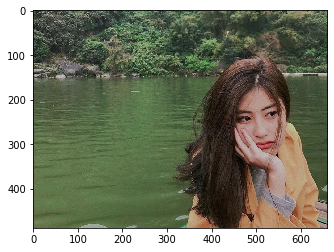

The segmented image:


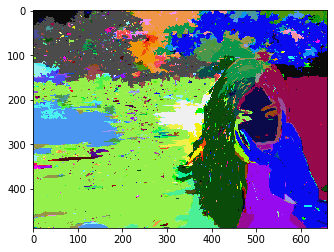

In [24]:
print('The origin image:')
%matplotlib inline
plt.imshow(img)
plt.show()
print('The segmented image:')
segmented_image=assign_segment(img_filter,k=20000)
%matplotlib inline
plt.imshow(segmented_image)
plt.show()

The original image:


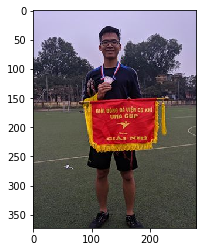

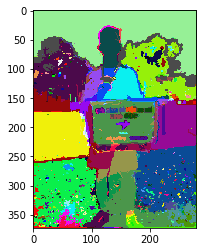

In [25]:
img=cv2.imread('Images/Figure2.jpg',cv2.IMREAD_COLOR)
if(len(img.shape)==3):img=img[:,:,::-1]
print('The original image:')
%matplotlib inline
plt.imshow(img)
plt.show()
#Blurring
img=gaussian_filter(img,sigma=0.8,kernel_size=5)
segmented_image=assign_segment(img,k=5000)
%matplotlib inline
plt.imshow(segmented_image)
plt.show()

The original image:


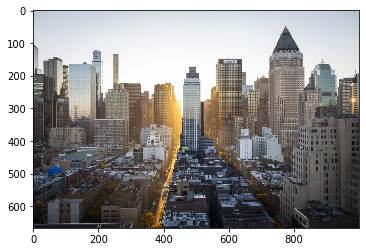

The segmented image:


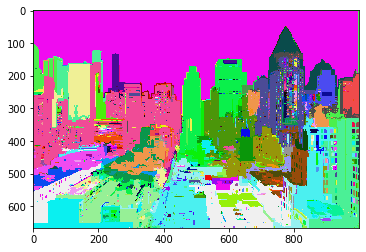

In [26]:
img=cv2.imread('Images/Figure3.jpeg',cv2.IMREAD_COLOR)
if(len(img.shape)==3):img=img[:,:,::-1]
print('The original image:')
%matplotlib inline
plt.imshow(img)
plt.show()
#Blurring
img=gaussian_filter(img,sigma=0.8,kernel_size=5)
segmented_image=assign_segment(img,k=20000)
print('The segmented image:')
%matplotlib inline
plt.imshow(segmented_image)
plt.show()

#### 8. An alternative approach: nearest neighbor Graph.

Một cách tiếp cận khác là thay vì sử dụng mỗi điểm pixel ban đầu, ta sẽ map nó lên một feature space khác. Sau đó tìm những cluster của những điểm giống nhau trong space này. Bây giờ đồ thị G(V,E) của ta là đồ thị mà có tập đỉnh là những điểm trong space mới. Các cạnh sẽ được formed giữa 2 đỉnh $(v_i,v_j)$ gần nhau trong space này. Ta có thể chọn mỗi một đỉnh sẽ được nối với một số lượng đỉnh nhất định nào đó gần nó nhất, hoặc nối với những đỉnh gần nó nhất trong một bán kính nào đó. Dù có chọn cách nối như nào, thì ta cũng nên chọn sao cho số cạnh là tuyến tính với số đỉnh (có như vậy thì khối lượng tính toán mới giảm được).  

Đối với weight trên một cạnh, ta có thể chọn là khoảng cách giữa 2 đỉnh nối bởi cạnh đó. Ta có thể sử dụng luôn L2 distance cho việc xây dựng weight.  
